In [2]:
import torch
import timm
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torch
import torch.optim as optim
import os
import random
import shutil
from torchvision import datasets
from csvlogger import CSVLogger
import pandas as pd
import matplotlib.pyplot as plt
import datetime

In [2]:
avail_pretrained_models = timm.list_models(pretrained=True)
print(avail_pretrained_models)

['bat_resnext26ts.ch_in1k', 'beit_base_patch16_224.in22k_ft_in22k', 'beit_base_patch16_224.in22k_ft_in22k_in1k', 'beit_base_patch16_384.in22k_ft_in22k_in1k', 'beit_large_patch16_224.in22k_ft_in22k', 'beit_large_patch16_224.in22k_ft_in22k_in1k', 'beit_large_patch16_384.in22k_ft_in22k_in1k', 'beit_large_patch16_512.in22k_ft_in22k_in1k', 'beitv2_base_patch16_224.in1k_ft_in1k', 'beitv2_base_patch16_224.in1k_ft_in22k', 'beitv2_base_patch16_224.in1k_ft_in22k_in1k', 'beitv2_large_patch16_224.in1k_ft_in1k', 'beitv2_large_patch16_224.in1k_ft_in22k', 'beitv2_large_patch16_224.in1k_ft_in22k_in1k', 'botnet26t_256.c1_in1k', 'caformer_b36.sail_in1k', 'caformer_b36.sail_in1k_384', 'caformer_b36.sail_in22k', 'caformer_b36.sail_in22k_ft_in1k', 'caformer_b36.sail_in22k_ft_in1k_384', 'caformer_m36.sail_in1k', 'caformer_m36.sail_in1k_384', 'caformer_m36.sail_in22k', 'caformer_m36.sail_in22k_ft_in1k', 'caformer_m36.sail_in22k_ft_in1k_384', 'caformer_s18.sail_in1k', 'caformer_s18.sail_in1k_384', 'caformer_s

In [3]:
print(f"Is CUDA supported by this system? {torch.cuda.is_available()}")
print(f"CUDA version: {torch.version.cuda}")
 
# Storing ID of current CUDA device
cuda_id = torch.cuda.current_device()
print(f"ID of current CUDA device: {torch.cuda.current_device()}")
       
print(f"Name of current CUDA device: {torch.cuda.get_device_name(cuda_id)}")

Is CUDA supported by this system? True
CUDA version: 11.8
ID of current CUDA device: 0
Name of current CUDA device: NVIDIA GeForce RTX 3060 Laptop GPU


In [4]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print(f"Device: {device}")

Device: cuda


In [5]:
print(os.listdir('Binary_ttv\\src')) # Preliminary Image Processing\Alzheimer_s Dataset_binary\src
print(os.listdir('Binary_ttv\\train'))
print(os.listdir('Binary_ttv\\test'))
print(os.listdir('Binary_ttv\\val'))

['Demented', 'NonDemented']
['Demented', 'NonDemented']
['Demented', 'NonDemented']
['Demented', 'NonDemented']


In [6]:
# Define transformations for image preprocessing
transform = transforms.Compose([
    transforms.Resize((176, 208)),  # Resize images to a common size (adjust as needed)
    transforms.ToTensor(),           # Convert images to tensors
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),  # Normalize using ImageNet stats
])

# Load training and testing datasets
train_dataset = ImageFolder(root='Binary_ttv\\train', transform=transform)
test_dataset = ImageFolder(root='Binary_ttv\\test', transform=transform)
val_dataset = ImageFolder(root='Binary_ttv\\val', transform=transform)

batch_size = 26  # Adjust as needed
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

print(len(train_loader))
print(len(test_loader))
print(len(val_loader))
print(len(train_dataset))
print(len(test_dataset))
print(len(val_dataset))

3661
776
499
95165
20170
12967


In [7]:
learning_rate = 0.0001
epochs = 100
patience = 5

Resnet50

In [9]:
model = timm.create_model('resnet50', pretrained=True, num_classes=2, drop_rate=0.2).to(device)

losslogger = CSVLogger('resnet50_loss.csv', fieldnames=["datetime", "batch", "epoch", "train_loss", "val_loss", "val_accuracy"])
acclogger = CSVLogger('resnet50_acc.csv', fieldnames=["datetime", "average_accuracy"])
loss_value = torch.nn.CrossEntropyLoss()

model_opt = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

# Training loop
num_epochs = epochs  
early_stopping = False  
best_loss = float('inf') 
counter = 0

print(f"Device: {device}")

print(f"Start time: {datetime.datetime.now()}")


for epoch in range(num_epochs):
    model.train()  
    # Training
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        model_opt.zero_grad()
        outputs = model(inputs)
        loss = loss_value(outputs, labels)
        loss.backward()
        model_opt.step()
        counter += 1
        if counter % 1800 == 0:
            print(f"Completed {counter} batches")
    
    # Validation
    model.eval()  
    total = 0
    correct = 0
    val_loss = 0.0
    for val_inputs, val_labels in val_loader:
        val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
        val_outputs = model(val_inputs)
        val_loss += loss_value(val_outputs, val_labels).item()
        _, predicted = torch.max(val_outputs.data, 1)
        total += val_labels.size(0)
        correct += (predicted == val_labels).sum().item()

    val_loss /= len(val_loader)
    val_accuracy = 100 * correct / total
    losslog_data = {"datetime": datetime.datetime.now(), "batch": batch_size, "epoch": epoch+1, "train_loss": loss.item(), "val_loss": val_loss, "val_accuracy": val_accuracy}
    losslogger.log(losslog_data)

    # Early stopping
    if val_loss < best_loss:
        best_loss = val_loss
        patience_counter = 0  
    else:
        patience_counter += 1  
        
        # If validation loss hasn't improved for 'patience' epochs, stop early
        if patience_counter >= patience:
            print("Early stopping triggered")
            early_stopping = True
            break
    
    if early_stopping:
        break
    
    print(f"Completed epoch {epoch + 1} with loss {loss.item()}, validation loss {val_loss}")

# -----------------------------------------

correct = 0
total = 0
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
acclog_data = {"datetime": datetime.datetime.now(), "average_accuracy": accuracy}
acclogger.log(acclog_data)
print('\n\nAccuracy on the test dataset: {:.6f}%'.format(accuracy), end="\n\n")

# -----------------------------------------


torch.save(model.state_dict(), 'resnet50.pth')

Device: cuda
Start time: 2023-11-04 23:07:44.892375
Completed 1800 batches
Completed 3600 batches
Completed epoch 1 with loss 0.6036391854286194, validation loss 0.4329794845235849
Completed 5400 batches
Completed 7200 batches
Completed epoch 2 with loss 0.3055563271045685, validation loss 0.3826148519311138
Completed 9000 batches
Completed 10800 batches
Completed epoch 3 with loss 0.15706248581409454, validation loss 0.3577156418408146
Completed 12600 batches
Completed 14400 batches
Completed epoch 4 with loss 0.48578959703445435, validation loss 0.34001256040444894
Completed 16200 batches
Completed 18000 batches
Completed epoch 5 with loss 0.5785778760910034, validation loss 0.3201413854008507
Completed 19800 batches
Completed 21600 batches
Completed epoch 6 with loss 0.13252775371074677, validation loss 0.3205596915313709
Completed 23400 batches
Completed 25200 batches
Completed epoch 7 with loss 0.4802648425102234, validation loss 0.30507203706452446
Completed 27000 batches
Complet

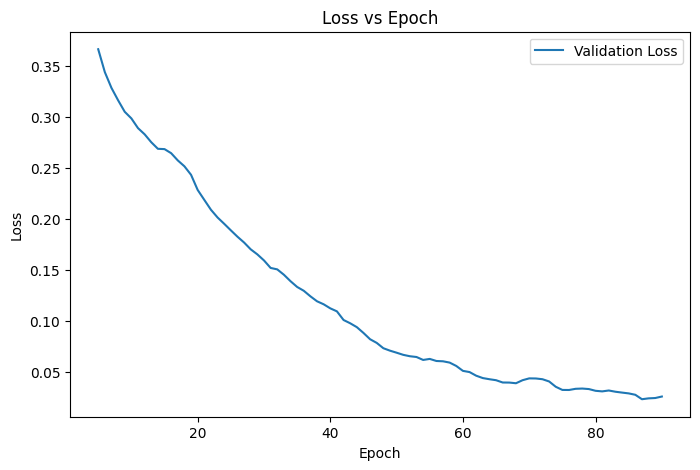

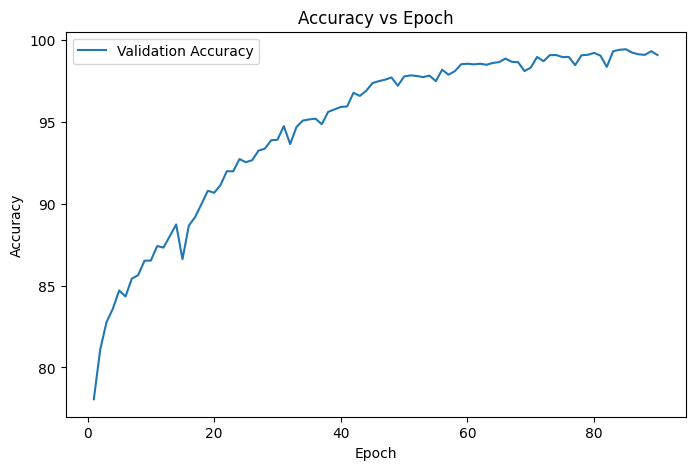

In [14]:
lossdf = pd.read_csv("resnet50_loss.csv", engine="pyarrow")

l = len(lossdf)
lossdf = lossdf.iloc[l - 90:, :]

# print(lossdf.iloc[0, :])

rolling_mean = lossdf["val_loss"].rolling(window=5).mean()
rolling_mean2 = lossdf["train_loss"].rolling(window=5).mean()

plt.figure(figsize=(8, 5))
plt.plot(lossdf["epoch"], rolling_mean, label="Validation Loss")
# plt.plot(lossdf["epoch"], rolling_mean2, label="Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss vs Epoch")
plt.legend()
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(lossdf["epoch"], lossdf["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Epoch")
plt.legend()
plt.show()

In [15]:

# # Import the timm pth models
# model = torch.load("mobilenetv3_large.pth")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Create an instance of the VGG16 model
model = timm.create_model('resnet50', pretrained=True, num_classes=2, drop_rate=0.2).to(device)

# Load the saved state dictionary into the model
model.load_state_dict(torch.load('resnet50.pth', map_location=device))

correct = 0
total = 0
all_predicted = []
all_labels = []
counter = 0

model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        all_predicted.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        counter += 1
        if counter % 5000 == 0:
            print(f"Completed {counter} batches")

accuracy = 100 * correct / total

print("Done testing")

Done testing




Accuracy on the test dataset: 99.345563%

Confusion Matrix:
 [[10063    24]
 [  108  9975]]


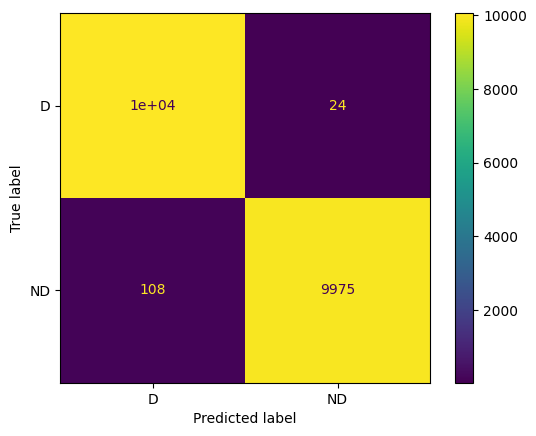


Manual Precision: 0.9975997599759976
Manual Recall: 0.9892889021124666

Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99     10087
           1       1.00      0.99      0.99     10083

    accuracy                           0.99     20170
   macro avg       0.99      0.99      0.99     20170
weighted avg       0.99      0.99      0.99     20170



AUC-ROC Score: 0.993455


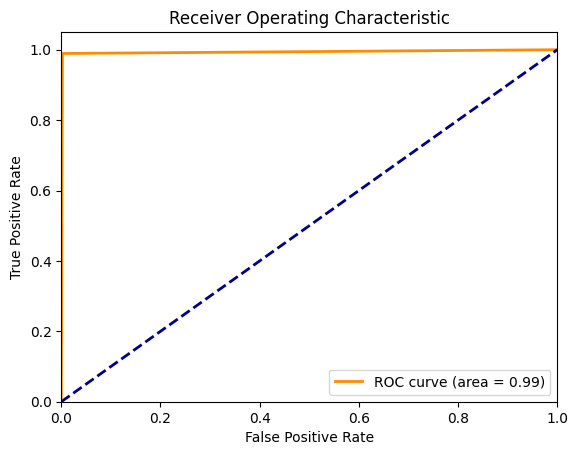

In [16]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, classification_report, auc, roc_curve

print('\n\nAccuracy on the test dataset: {:.6f}%'.format(accuracy), end="\n\n")

# Calculate the confusion matrix
confusion = confusion_matrix(all_labels, all_predicted)
print("Confusion Matrix:\n", confusion)
cm = ConfusionMatrixDisplay(confusion_matrix=confusion, display_labels=["D", "ND"])
cm.plot()
plt.show()
print(cm, end='\n\n')

# Generate precision-recall metrics
precision_manual = precision_score(all_labels, all_predicted)
recall_manual = recall_score(all_labels, all_predicted)

print("Manual Precision:", precision_manual)
print("Manual Recall:", recall_manual, end="\n\n")

# Generate classification report
report = classification_report(all_labels, all_predicted)
print("Classification Report:\n", report, end='\n\n')

# Calculate ROC curve and AUC-ROC score
# fpr, tpr, thresholds = roc_curve(all_labels, outputs.cpu().numpy()[:, 1].astype(float))
fpr, tpr, thresholds = roc_curve(y_true=all_labels, y_score=all_predicted)
roc_auc = auc(fpr, tpr)
print("\nAUC-ROC Score: {:.6f}".format(roc_auc))

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [10]:
lossdf = pd.read_csv("vgg16_loss.csv", engine="pyarrow")

rolling_mean = lossdf["val_loss"].rolling(window=5).mean()
rolling_mean2 = lossdf["train_loss"].rolling(window=5).mean()

plt.figure(figsize=(8, 5))
plt.plot(lossdf["epoch"], rolling_mean, label="Validation Loss")
plt.plot(lossdf["epoch"], rolling_mean2, label="Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss vs Epoch")
plt.legend()
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(lossdf["epoch"], lossdf["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Epoch")
plt.legend()
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'vgg16_loss.csv'

Mobilenet

In [19]:
model = timm.create_model('mobilenetv3_large_100', pretrained=True, num_classes=2, drop_rate=0.2).to(device)

losslogger = CSVLogger('mobilenetv3_large_loss.csv', fieldnames=["datetime", "batch", "epoch", "train_loss", "val_loss", "val_accuracy"])
acclogger = CSVLogger('mobilenetv3_large_acc.csv', fieldnames=["datetime", "average_accuracy"])
loss_value = torch.nn.CrossEntropyLoss()

model_opt = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

# Training loop
num_epochs = epochs  
early_stopping = False  
best_loss = float('inf') 

print(f"Device: {device}")

print(f"Start time: {datetime.datetime.now()}")


for epoch in range(num_epochs):
    model.train()  
    # Training
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        model_opt.zero_grad()
        outputs = model(inputs)
        loss = loss_value(outputs, labels)
        loss.backward()
        model_opt.step()
    
    # Validation
    model.eval()  
    total = 0
    correct = 0
    val_loss = 0.0
    for val_inputs, val_labels in val_loader:
        val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
        val_outputs = model(val_inputs)
        val_loss += loss_value(val_outputs, val_labels).item()
        _, predicted = torch.max(val_outputs.data, 1)
        total += val_labels.size(0)
        correct += (predicted == val_labels).sum().item()

    val_loss /= len(val_loader)
    val_accuracy = 100 * correct / total
    losslog_data = {"datetime": datetime.datetime.now(), "batch": batch_size, "epoch": epoch+1, "train_loss": loss.item(), "val_loss": val_loss, "val_accuracy": val_accuracy}
    losslogger.log(losslog_data)

    # Early stopping
    if val_loss < best_loss:
        best_loss = val_loss
        patience_counter = 0  
    else:
        patience_counter += 1  
        
        # If validation loss hasn't improved for 'patience' epochs, stop early
        if patience_counter >= patience:
            print("Early stopping triggered")
            early_stopping = True
            break
    
    if early_stopping:
        break
    
    print(f"Completed epoch {epoch + 1} with loss {loss.item()}, validation loss {val_loss}")

# -----------------------------------------

correct = 0
total = 0
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
acclog_data = {"datetime": datetime.datetime.now(), "average_accuracy": accuracy}
acclogger.log(acclog_data)
print('\n\nAccuracy on the test dataset: {:.6f}%'.format(accuracy), end="\n\n")

# Save the model
torch.save(model.state_dict(), 'mobilenetv3_large.pth')


Device: cuda
Start time: 2023-11-02 14:25:26.683058
Completed epoch 1 with loss 0.04055780544877052, validation loss 0.1952510912747868
Completed epoch 2 with loss 0.010466552339494228, validation loss 0.10387345766676566
Completed epoch 3 with loss 0.01143277995288372, validation loss 0.0576947878786769
Completed epoch 4 with loss 0.08788588643074036, validation loss 0.04462453438539581
Completed epoch 5 with loss 0.013846207410097122, validation loss 0.027133099366916196
Completed epoch 6 with loss 0.01576865278184414, validation loss 0.0197745921489662
Completed epoch 7 with loss 0.0002943530271295458, validation loss 0.016098634850136503
Completed epoch 8 with loss 0.0008144935127347708, validation loss 0.014140961983253549
Completed epoch 9 with loss 5.0645190640352666e-05, validation loss 0.011355322558904467
Completed epoch 10 with loss 0.0006969619425944984, validation loss 0.012647938509896435
Completed epoch 11 with loss 6.758944073226303e-05, validation loss 0.00806190688465

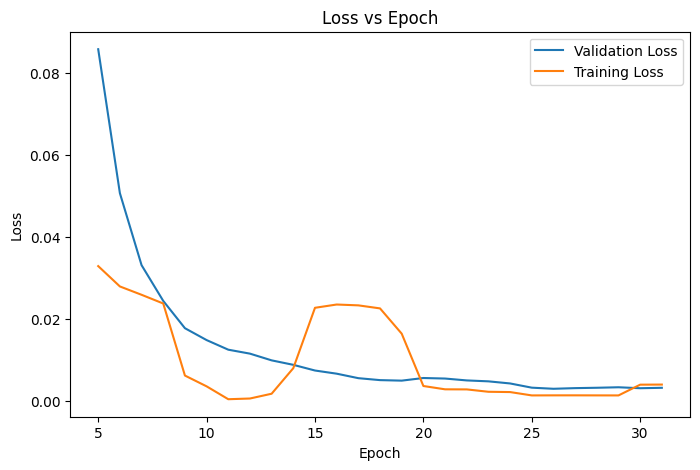

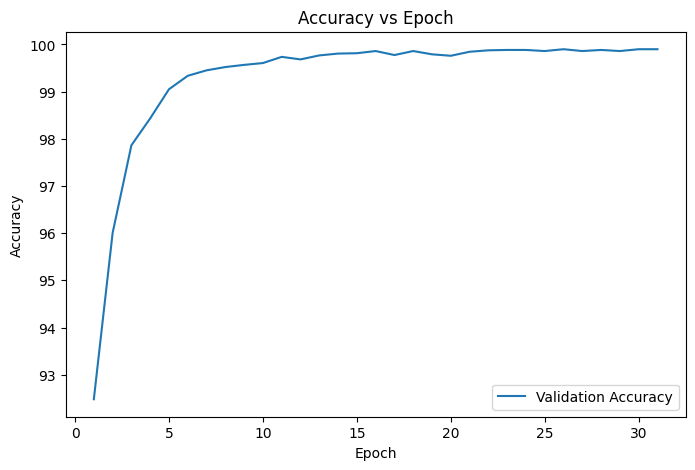

In [20]:
lossdf = pd.read_csv("mobilenetv3_large_loss.csv", engine="pyarrow")
rolling_mean = lossdf["val_loss"].rolling(window=5).mean()
rolling_mean2 = lossdf["train_loss"].rolling(window=5).mean()

plt.figure(figsize=(8, 5))
plt.plot(lossdf["epoch"], rolling_mean, label="Validation Loss")
plt.plot(lossdf["epoch"], rolling_mean2, label="Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss vs Epoch")
plt.legend()
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(lossdf["epoch"], lossdf["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Epoch")
plt.legend()
plt.show()

Densenet

In [29]:
model = timm.create_model('densenet121', pretrained=True, num_classes=2, drop_rate=0.2).to(device)

losslogger = CSVLogger('densenet121_loss.csv', fieldnames=["datetime", "batch", "epoch", "train_loss", "val_loss", "val_accuracy"])
acclogger = CSVLogger('densenet121_acc.csv', fieldnames=["datetime", "average_accuracy"])
loss_value = torch.nn.CrossEntropyLoss()

model_opt = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

# Training loop
num_epochs = epochs  
early_stopping = False  
best_loss = float('inf') 

print(f"Device: {device}")

print(f"Start time: {datetime.datetime.now()}")


for epoch in range(num_epochs):
    model.train()  
    # Training
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        model_opt.zero_grad()
        outputs = model(inputs)
        loss = loss_value(outputs, labels)
        loss.backward()
        model_opt.step()
    
    # Validation
    model.eval()  
    total = 0
    correct = 0
    val_loss = 0.0
    for val_inputs, val_labels in val_loader:
        val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
        val_outputs = model(val_inputs)
        val_loss += loss_value(val_outputs, val_labels).item()
        _, predicted = torch.max(val_outputs.data, 1)
        total += val_labels.size(0)
        correct += (predicted == val_labels).sum().item()

    val_loss /= len(val_loader)
    val_accuracy = 100 * correct / total
    losslog_data = {"datetime": datetime.datetime.now(), "batch": batch_size, "epoch": epoch+1, "train_loss": loss.item(), "val_loss": val_loss, "val_accuracy": val_accuracy}
    losslogger.log(losslog_data)

    # Early stopping
    if val_loss < best_loss:
        best_loss = val_loss
        patience_counter = 0  
    else:
        patience_counter += 1  
        
        # If validation loss hasn't improved for 'patience' epochs, stop early
        if patience_counter >= patience:
            print("Early stopping triggered")
            early_stopping = True
            break
    
    if early_stopping:
        break
    
    print(f"Completed epoch {epoch + 1} with loss {loss.item()}, validation loss {val_loss}")

# -----------------------------------------

correct = 0
total = 0
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
acclog_data = {"datetime": datetime.datetime.now(), "average_accuracy": accuracy}
acclogger.log(acclog_data)
print('\n\nAccuracy on the test dataset: {:.6f}%'.format(accuracy), end="\n\n")

# Save the model
torch.save(model.state_dict(), 'densenet121_large.pth')


Device: cuda
Start time: 2023-11-02 21:26:36.331384


KeyboardInterrupt: 

In [ ]:
lossdf = pd.read_csv("densenet121_loss.csv", engine="pyarrow")
rolling_mean = lossdf["val_loss"].rolling(window=5).mean()
rolling_mean2 = lossdf["train_loss"].rolling(window=5).mean()

plt.figure(figsize=(8, 5))
plt.plot(lossdf["epoch"], rolling_mean, label="Validation Loss")
plt.plot(lossdf["epoch"], rolling_mean2, label="Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss vs Epoch")
plt.legend()
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(lossdf["epoch"], lossdf["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Epoch")
plt.legend()
plt.show()

InceptionV4

In [30]:
model = timm.create_model('inception_v4', pretrained=True, num_classes=2, drop_rate=0.2).to(device)

losslogger = CSVLogger('inception_v4_loss.csv', fieldnames=["datetime", "batch", "epoch", "train_loss", "val_loss", "val_accuracy"])
acclogger = CSVLogger('inception_v4_acc.csv', fieldnames=["datetime", "average_accuracy"])
loss_value = torch.nn.CrossEntropyLoss()

model_opt = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

# Training loop
num_epochs = epochs  
early_stopping = False  
best_loss = float('inf') 

print(f"Device: {device}")

print(f"Start time: {datetime.datetime.now()}")


for epoch in range(num_epochs):
    model.train()  
    # Training
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        model_opt.zero_grad()
        outputs = model(inputs)
        loss = loss_value(outputs, labels)
        loss.backward()
        model_opt.step()
    
    # Validation
    model.eval()  
    total = 0
    correct = 0
    val_loss = 0.0
    for val_inputs, val_labels in val_loader:
        val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
        val_outputs = model(val_inputs)
        val_loss += loss_value(val_outputs, val_labels).item()
        _, predicted = torch.max(val_outputs.data, 1)
        total += val_labels.size(0)
        correct += (predicted == val_labels).sum().item()

    val_loss /= len(val_loader)
    val_accuracy = 100 * correct / total
    losslog_data = {"datetime": datetime.datetime.now(), "batch": batch_size, "epoch": epoch+1, "train_loss": loss.item(), "val_loss": val_loss, "val_accuracy": val_accuracy}
    losslogger.log(losslog_data)

    # Early stopping
    if val_loss < best_loss:
        best_loss = val_loss
        patience_counter = 0  
    else:
        patience_counter += 1  
        
        # If validation loss hasn't improved for 'patience' epochs, stop early
        if patience_counter >= patience:
            print("Early stopping triggered")
            early_stopping = True
            break
    
    if early_stopping:
        break
    
    print(f"Completed epoch {epoch + 1} with loss {loss.item()}, validation loss {val_loss}")

# -----------------------------------------

correct = 0
total = 0
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
acclog_data = {"datetime": datetime.datetime.now(), "average_accuracy": accuracy}
acclogger.log(acclog_data)
print('\n\nAccuracy on the test dataset: {:.6f}%'.format(accuracy), end="\n\n")

# Save the model
torch.save(model.state_dict(), 'inception_v4_large.pth')


Device: cuda
Start time: 2023-11-02 21:41:48.314433


KeyboardInterrupt: 

In [ ]:
lossdf = pd.read_csv("inception_v4_loss.csv", engine="pyarrow")
rolling_mean = lossdf["val_loss"].rolling(window=5).mean()
rolling_mean2 = lossdf["train_loss"].rolling(window=5).mean()

plt.figure(figsize=(8, 5))
plt.plot(lossdf["epoch"], rolling_mean, label="Validation Loss")
plt.plot(lossdf["epoch"], rolling_mean2, label="Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss vs Epoch")
plt.legend()
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(lossdf["epoch"], lossdf["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Epoch")
plt.legend()
plt.show()

Vgg16

In [ ]:
model = timm.create_model('vgg16', pretrained=True, num_classes=2, drop_rate=0.2).to(device)

losslogger = CSVLogger('vgg16_loss.csv', fieldnames=["datetime", "batch", "epoch", "train_loss", "val_loss", "val_accuracy"])
acclogger = CSVLogger('vgg16_acc.csv', fieldnames=["datetime", "average_accuracy"])
loss_value = torch.nn.CrossEntropyLoss()

model_opt = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

# Training loop
num_epochs = epochs  
early_stopping = False  
best_loss = float('inf') 

print(f"Device: {device}")

print(f"Start time: {datetime.datetime.now()}")


for epoch in range(num_epochs):
    model.train()  
    # Training
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        model_opt.zero_grad()
        outputs = model(inputs)
        loss = loss_value(outputs, labels)
        loss.backward()
        model_opt.step()

    print("Training done")
    
    # Validation
    model.eval()  
    total = 0
    correct = 0
    val_loss = 0.0
    for val_inputs, val_labels in val_loader:
        val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
        val_outputs = model(val_inputs)
        val_loss += loss_value(val_outputs, val_labels).item()
        _, predicted = torch.max(val_outputs.data, 1)
        total += val_labels.size(0)
        correct += (predicted == val_labels).sum().item()

    print("Validation done")
    val_loss /= len(val_loader)
    val_accuracy = 100 * correct / total
    losslog_data = {"datetime": datetime.datetime.now(), "batch": batch_size, "epoch": epoch+1, "train_loss": loss.item(), "val_loss": val_loss, "val_accuracy": val_accuracy}
    losslogger.log(losslog_data)

    # Early stopping
    if val_loss < best_loss:
        best_loss = val_loss
        patience_counter = 0  
    else:
        patience_counter += 1  
        
        # If validation loss hasn't improved for 'patience' epochs, stop early
        if patience_counter >= patience:
            print("Early stopping triggered")
            early_stopping = True
            break
    
    if early_stopping:
        break
    
    print(f"Completed epoch {epoch + 1} with loss {loss.item()}, validation loss {val_loss}")

# -----------------------------------------

correct = 0
total = 0
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
acclog_data = {"datetime": datetime.datetime.now(), "average_accuracy": accuracy}
acclogger.log(acclog_data)
print('\n\nAccuracy on the test dataset: {:.6f}%'.format(accuracy), end="\n\n")

# Save the model
torch.save(model.state_dict(), 'vgg16_large.pth')

# -----------------------------------------

Device: cuda
Start time: 2023-11-02 14:14:49.279462


KeyboardInterrupt: 

Inceptionv3


#### Testing the models and getting confusion matrix, precision recall, and auc-roc 

In [15]:
print(device)

cuda


In [9]:
import torch
import timm
import datetime
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, auc, roc_curve, roc_auc_score, precision_score, recall_score, ConfusionMatrixDisplay


In [10]:

# # Import the timm pth models
# model = torch.load("mobilenetv3_large.pth")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Create an instance of the VGG16 model
model = timm.create_model('mobilenetv3_large_100', num_classes=2, drop_rate=0.2).to(device)

# Load the saved state dictionary into the model
model.load_state_dict(torch.load('mobilenetv3_large.pth', map_location=device))

correct = 0
total = 0
all_predicted = []
all_labels = []
counter = 0

model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        all_predicted.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        counter += 1
        if counter % 5000 == 0:
            print(f"Completed {counter} batches")

accuracy = 100 * correct / total

print("Done testing")

Done testing


In [11]:
# y_true = all_labels  # Ensure y_true is a one-dimensional array
# y_score = outputs.cpu().numpy()[:, 1].astype(float)  # Ensure y_score is a one-dimensional array with the same length

# print(y_true.shape)
# print(y_score.shape)



Accuracy on the test dataset: 99.960337%

Confusion Matrix:
 [[10082     5]
 [    3 10080]]


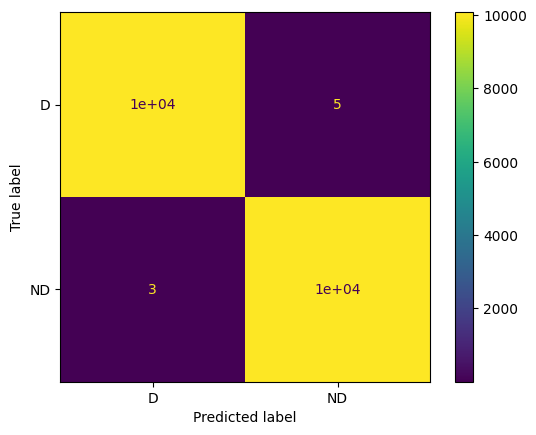


Manual Precision: 0.9995042141794744
Manual Recall: 0.999702469503124

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     10087
           1       1.00      1.00      1.00     10083

    accuracy                           1.00     20170
   macro avg       1.00      1.00      1.00     20170
weighted avg       1.00      1.00      1.00     20170



AUC-ROC Score: 0.999603


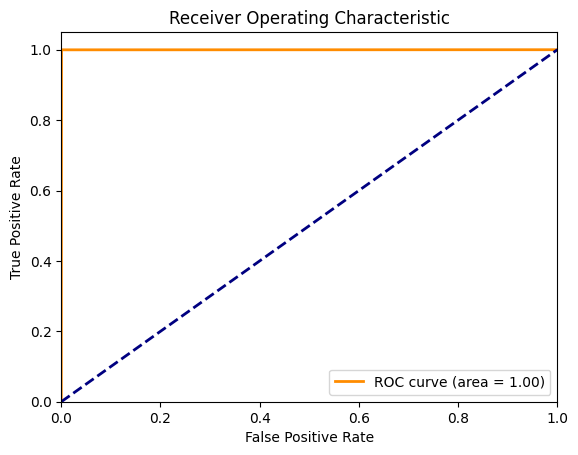

In [13]:
print('\n\nAccuracy on the test dataset: {:.6f}%'.format(accuracy), end="\n\n")

# Calculate the confusion matrix
confusion = confusion_matrix(all_labels, all_predicted)
print("Confusion Matrix:\n", confusion)
cm = ConfusionMatrixDisplay(confusion_matrix=confusion, display_labels=["D", "ND"])
cm.plot()
plt.show()
print(cm, end='\n\n')

# Generate precision-recall metrics
precision_manual = precision_score(all_labels, all_predicted)
recall_manual = recall_score(all_labels, all_predicted)

print("Manual Precision:", precision_manual)
print("Manual Recall:", recall_manual, end="\n\n")

# Generate classification report
report = classification_report(all_labels, all_predicted)
print("Classification Report:\n", report, end='\n\n')

# Calculate ROC curve and AUC-ROC score
# fpr, tpr, thresholds = roc_curve(all_labels, outputs.cpu().numpy()[:, 1].astype(float))
fpr, tpr, thresholds = roc_curve(y_true=all_labels, y_score=all_predicted)
roc_auc = auc(fpr, tpr)
print("\nAUC-ROC Score: {:.6f}".format(roc_auc))

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

#### Yet another test

In [6]:
# Define transformations for image preprocessing
transform2 = transforms.Compose([
    transforms.Resize((176, 208)),  # Resize images to a common size (adjust as needed)
    transforms.ToTensor(),           # Convert images to tensors
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),  # Normalize using ImageNet stats
])

# Load training and testing datasets
# train_dataset = ImageFolder(root='Binary_ttv\\train', transform=transform2)
test_dataset = ImageFolder(root='NewBinary_TTV\\test', transform=transform2)
# val_dataset = ImageFolder(root='Binary_ttv\\val', transform=transform2)

batch_size = 26  # Adjust as needed
# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)
# val_loader = DataLoader(val_dataset, batch_size=batch_size)

# print(len(train_loader))
print(len(test_loader))
# print(len(val_loader))
# print(len(train_dataset))
print(len(test_dataset))
# print(len(val_dataset))

776
20166


In [7]:
import torch
import timm
import datetime
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, auc, roc_curve, precision_score, recall_score, ConfusionMatrixDisplay

Mobilenet

In [8]:

# # Import the timm pth models
# model = torch.load("mobilenetv3_large.pth")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")
# Create an instance of the model
model = timm.create_model('mobilenetv3_large_100', num_classes=2, drop_rate=0.2).to(device)

# Load the saved state dictionary into the model
model.load_state_dict(torch.load('Models/Model_mobilenetv3_large.pth', map_location=device))

correct = 0
total = 0
all_predicted = []
all_labels = []
counter = 0

model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        all_predicted.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        counter += 1
        if counter % 5000 == 0:
            print(f"Completed {counter} batches")

accuracy = 100 * correct / total

print("Done testing")



Device: cuda
Done testing




Accuracy on the test dataset: 99.980165%

Confusion Matrix:
 [[10080     3]
 [    1 10082]]


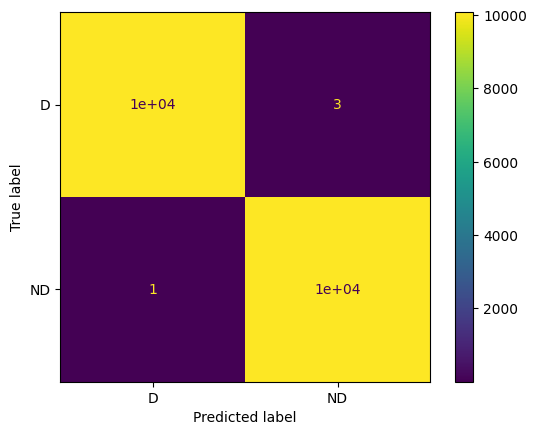


Manual Precision: 0.9997025285076847
Manual Recall: 0.999900823167708

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     10083
           1       1.00      1.00      1.00     10083

    accuracy                           1.00     20166
   macro avg       1.00      1.00      1.00     20166
weighted avg       1.00      1.00      1.00     20166



AUC-ROC Score: 0.999802


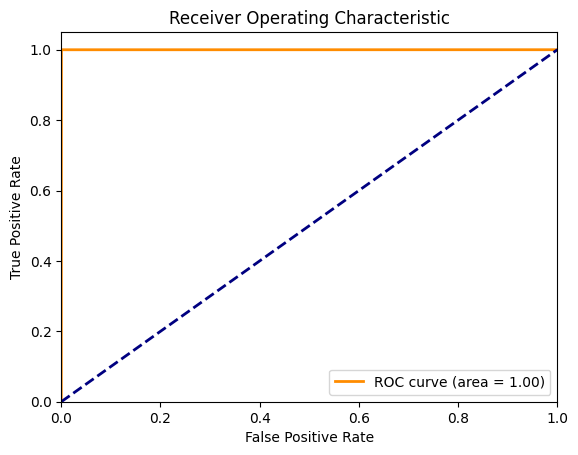

In [9]:
print('\n\nAccuracy on the test dataset: {:.6f}%'.format(accuracy), end="\n\n")

# Calculate the confusion matrix
confusion = confusion_matrix(all_labels, all_predicted)
print("Confusion Matrix:\n", confusion)
cm = ConfusionMatrixDisplay(confusion_matrix=confusion, display_labels=["D", "ND"])
cm.plot()
plt.show()
print(cm, end='\n\n')

# Generate precision-recall metrics
precision_manual = precision_score(all_labels, all_predicted)
recall_manual = recall_score(all_labels, all_predicted)

print("Manual Precision:", precision_manual)
print("Manual Recall:", recall_manual, end="\n\n")

# Generate classification report
report = classification_report(all_labels, all_predicted)
print("Classification Report:\n", report, end='\n\n')

# Calculate ROC curve and AUC-ROC score
# fpr, tpr, thresholds = roc_curve(all_labels, outputs.cpu().numpy()[:, 1].astype(float))
fpr, tpr, thresholds = roc_curve(y_true=all_labels, y_score=all_predicted)
roc_auc = auc(fpr, tpr)
print("\nAUC-ROC Score: {:.6f}".format(roc_auc))

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

Resnet50

In [10]:

# # Import the timm pth models
# model = torch.load("mobilenetv3_large.pth")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")
# Create an instance of the model
model = timm.create_model('resnet50', num_classes=2, drop_rate=0.2).to(device)

# Load the saved state dictionary into the model
model.load_state_dict(torch.load('Models/Model_resnet50.pth', map_location=device))

correct = 0
total = 0
all_predicted = []
all_labels = []
counter = 0

model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        all_predicted.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        counter += 1
        if counter % 5000 == 0:
            print(f"Completed {counter} batches")

accuracy = 100 * correct / total

print("Done testing")



Device: cuda
Done testing




Accuracy on the test dataset: 99.742140%

Confusion Matrix:
 [[10080     3]
 [   49 10034]]


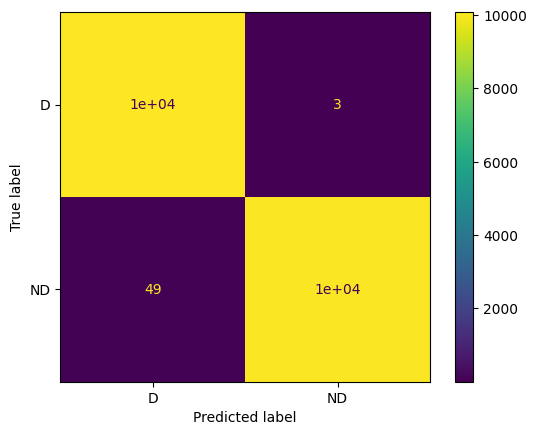


Manual Precision: 0.9997011059081399
Manual Recall: 0.9951403352176932

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     10083
           1       1.00      1.00      1.00     10083

    accuracy                           1.00     20166
   macro avg       1.00      1.00      1.00     20166
weighted avg       1.00      1.00      1.00     20166



AUC-ROC Score: 0.997421


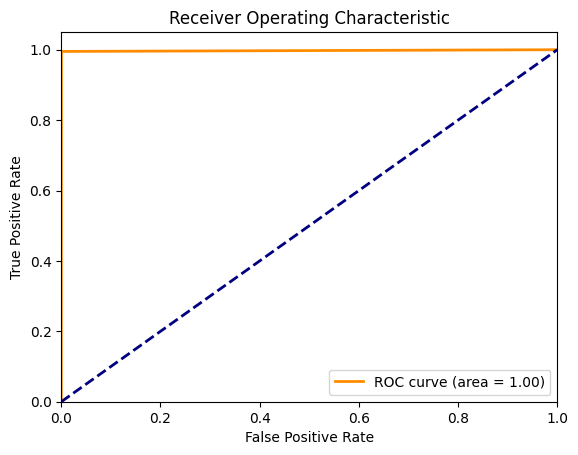

In [11]:
print('\n\nAccuracy on the test dataset: {:.6f}%'.format(accuracy), end="\n\n")

# Calculate the confusion matrix
confusion = confusion_matrix(all_labels, all_predicted)
print("Confusion Matrix:\n", confusion)
cm = ConfusionMatrixDisplay(confusion_matrix=confusion, display_labels=["D", "ND"])
cm.plot()
plt.show()
print(cm, end='\n\n')

# Generate precision-recall metrics
precision_manual = precision_score(all_labels, all_predicted)
recall_manual = recall_score(all_labels, all_predicted)

print("Manual Precision:", precision_manual)
print("Manual Recall:", recall_manual, end="\n\n")

# Generate classification report
report = classification_report(all_labels, all_predicted)
print("Classification Report:\n", report, end='\n\n')

# Calculate ROC curve and AUC-ROC score
# fpr, tpr, thresholds = roc_curve(all_labels, outputs.cpu().numpy()[:, 1].astype(float))
fpr, tpr, thresholds = roc_curve(y_true=all_labels, y_score=all_predicted)
roc_auc = auc(fpr, tpr)
print("\nAUC-ROC Score: {:.6f}".format(roc_auc))

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()